# Kirchhoff’s plate theory - Bending waves 

Most of the work is based on my Masters Thesis "Dynamic response predictions of structures subjected to pyroshock excitation"


The flexural bending waves of a thin plate according to Kirchhoff’s plate theory are governed by the equation below.

$$B'{\nabla^2}({\nabla^2}w) + {\rho}h\frac{\partial^2 w}{\partial t}=p(x,y,t),$$

$${\nabla^2}=\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2},$$

$$B'=\frac{Eh^3}{12(1-{\nu})},$$


where $w$ is the displacement, $B'$ is the bending stiffness of the plate, ${\nabla^2}$ the Laplace operator, ${\rho}$ the density, $h$ the plate thickness, ${\nu}$ Poisson’s ratio and $E$ Young’s Modulus. On the right hand side of Equation (1), the input force per unit area is given by $p(x, y, t)$.

Kirchhoff plate theory is valid for thin plates. The criteria for assuming a thin plate is when the product of the wave number and the thickness of the plate is smaller than unity [13,14].

$$k_Bh < 1 $$

The wave number for bending waves in a thin plate is given by:

$$k_B = \sqrt[4]{\frac{{\rho}h{\omega}^2}{B'}}$$

Damping can be introduced into the equations by using a complex Young’s modulus like $E_{complex}= E(1+i{\eta})$ where ${\eta}$
is the loss factor which is related to the critical damping ratio ${\zeta}$ by ${\eta}=2{\zeta}$.



# Application of Theory

## Infinite Plate
A propagating plane bending wave in an infinite plate with the velocity $v$ normal to x-y-plane according to the figure below can be expressed as

$$v(r, t)=i{\omega}{\hat{A}}e^{i({\omega}t-kr)},$$

where $r$ is the distance from the excitation point and $\hat{A}$ is the complex amplitude of the velocity.

Assuming a point force $F=\hat{F_0}e^{i{\omega}t}$, omitting the time dependence and inserting the force and velocity into Equation (3.1) gives the solution from Cremer et al [4, Section 5.3.3],

$$v(r)=\hat{F_0}Y_0\left[H_0^{(2)}(k_Br) - H_0^{(2)}(-ik_Br) \right]=\hat{F_0}Y_0\Pi(k_Br),$$

where $\hat{F_0}$ is the complex force amplitude, $Y_0$ is the point mobility and $H_0^{(2)}$ the Hankel function of second kind. The propagation function $\Pi(k_Br)$ is also introduced for the difference between the Hankel functions, Cremer et al.

The equation can be evaluated by applying a FFT of a time-domain force, $\hat{F_0}$. By inverse FFT the time-domain response at a distance $r$ from the source can be obtained.

<img src="plate.png"/>

# Let's code the ifinite plate solution

But let us first define an excitation force in form of half sine impulse in the time-domain.

In [129]:
# import modules
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftfreq, rfft, irfft, rfftfreq
from scipy.special import hankel2

Half sine impulse source padded with zeros before and after pulse:

In [130]:
def half_sine(tau=1e-3,fs=10000):
    t =  np.linspace(0.0, tau, fs*tau) # start, end, num-points
    #print(t)
    xpuls = np.sin(np.pi*t/tau)
    xzeros=np.zeros(2*(len(t))) # Zero padding 2*tau
    x = np.concatenate((xzeros,xpuls),axis=0) # pre-padding of zeros
    x = np.concatenate((x,xzeros),axis=0) # end-padding of zeros
    return x

Function to make a time vector of correct size:

In [131]:
def maketime(x=254,fs=10000):
    tend = x.size/fs
    npoints = fs*tend
    t = np.linspace(0.0,tend,npoints) # arguments: start, end, num-points
    return t

Implementation of the point excited infinite plate:

In [132]:
def infinite_plate(f=None, Famp=None, E=210E9, rho=7800.0, 
                   eta=0.01, h=6.3E-3, nu=0.31, r=0.2):
    """Returns displacement w, velocity v and 
    acceleration a, of an infinite plate at a 
    distance r from the source 
    according to Cremer et al sec 5.3.3
    """
    if f is None:
        # Default frequency range if not specified
        f = np.arange(1,20000,1)
        
    if Famp is None:
        #Unity Amplitude if not specified
        Famp = np.ones(f.size)
    
    omega = 2*np.pi*f # Angular frequency
    Ecomp = E*(1.0+1j*eta) # Complex E-modulus
    B = (Ecomp*h**3)/(12*(1-nu**2)); # Bending stiffness
    k = ((rho*h*omega**2)/B)**(1.0/4) # Wavenumber
    Y = 1/(8*np.sqrt(B*rho*h)) # Point mobility
    
    # Velocity of plate Cremer et al sec 5.3.3
    v = Famp*Y*(hankel2(0,k*r)-hankel2(0,-1j*k*r))
    # Displacement
    w = v/(1j*omega)
    # Acceleration of plate
    a = 1j*omega*v
    return w, v, a, f, Famp

Let's try the functions!
First we'll define an half sine impulse with an amplitude of 1000 N and a duration of 1 ms:

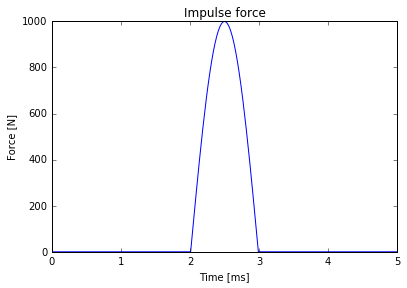

In [133]:
fs=40000
tau = 1e-3
x = 1000*half_sine(tau,fs)
t = maketime(x,fs)


fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # lower, bottom, width, height (range 0 to 1)
axes.plot(t*1000, x)
axes.set_xlabel('Time [ms]')
axes.set_ylabel('Force [N]')
axes.set_title('Impulse force');

The rfft() is used to transform the impulse to the frequency domain. rfft() returns the positive frequencies, fft() returns the negative and positive frequencies.

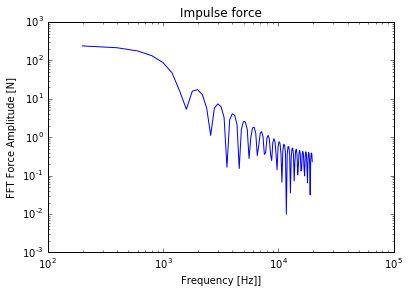

In [149]:
# FFT of impulse
N = len(t) # Number of sample points
dt = t[1]-t[0] # time step
Famp = 2*rfft(x,N)/N # FFT of force
f = rfftfreq(N,dt) # Frequencies
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # lower, bottom, width, height (range 0 to 1)
axes.loglog(f, np.abs(Famp))
axes.set_xlabel('Frequency [Hz]]')
axes.set_ylabel('FFT Force Amplitude [N]')
axes.set_title('Impulse force');

By inverse FFT the spectrum can be transformed back to the time-domain:

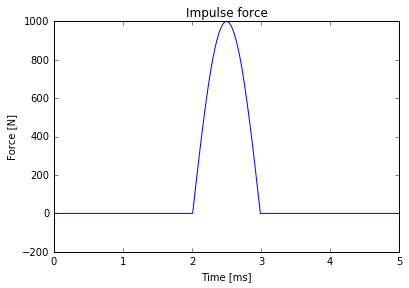

In [135]:
Ftime = N*irfft(Famp,N)/2
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # lower, bottom, width, height (range 0 to 1)
axes.plot(t*1000, Ftime)
axes.set_xlabel('Time [ms]')
axes.set_ylabel('Force [N]')
axes.set_title('Impulse force');

Lets investigate the response of the infinite plate in the frequency domain by creating the FRF between the input force and the response.

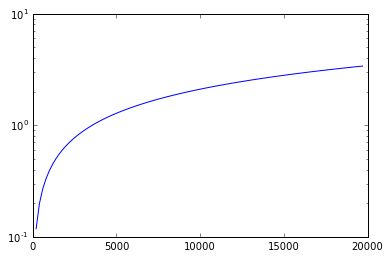

In [154]:
# Plate properties
rho = 7800.0 # Density of plate material
E = 210E9 # Youngs Modulus
eta = 0.01 # Loss factor
nu = 0.31 # Poissons ratio
h = 6.3E-3 # Plate thickness
r = 0.4 # Distance from source

w, v, a, freq, Finf = infinite_plate(f, Famp, E, rho, eta, h, nu, r)

FRF = a[1:-1]/Finf[1:-1]
plt.semilogy(freq[1:-1], np.abs(FRF));

One numerical issue of the infinite-plate equation is how to deal with the zero frequency (DC-component) since $H_0^{(2)}(0)= NaN+NaNj$.
How will this affect the results by removing the zero frequency, or setting it to a very small number? 
Lets investigate this before we transform the plate response to the time-domain.

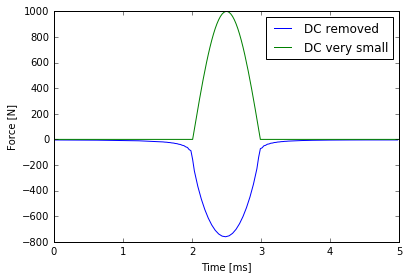

In [137]:
# Inverse FFT
# Lets remove the DC component
f_dc=f[1::]
F_dc=Famp[1::]
Ft_dc = N*irfft(F_dc,N-1)/2 #Signal is 1 point shorter N-1
tdc = maketime(Ft_dc,fs)

# Lets set the DC component to "very small"
f_s=f
f_s[0] = 1e-9
F_s=Famp
Ft_s = N*irfft(F_s,N)/2
ts = maketime(Ft_s,fs)


fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # lower, bottom, width, height (range 0 to 1)
axes.plot(tdc*1000, Ft_dc, label="DC removed")
axes.plot(ts*1000,Ft_s,label="DC very small")
axes.legend()
axes.set_xlabel('Time [ms]')
axes.set_ylabel('Force [N]');

As one can see, we get phase and amplitude deviations if we completely remove the DC component. Lets check the error between the original signal and the modified DC signal.

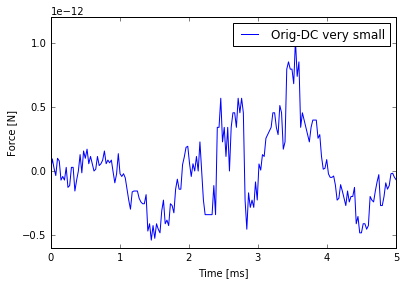

In [138]:
error = x-Ft_s
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # lower, bottom, width, height (range 0 to 1)
axes.plot(t*1000, error, label="Orig-DC very small")
axes.legend()
axes.set_xlabel('Time [ms]')
axes.set_ylabel('Force [N]');

It looks like setting the zero frequency to a very small number is good enough!

In [139]:
f[0]=1e-9
# Plate properties
rho = 7800.0 # Density of plate material
E = 210E9 # Youngs Modulus
eta = 0.01 # Loss factor
nu = 0.31 # Poissons ratio
h = 6.3E-3 # Plate thickness
r = 0.4 # Distance from source

w, v, a, freq, Finf = infinite_plate(f, Famp, E, rho, eta, h, nu, r)

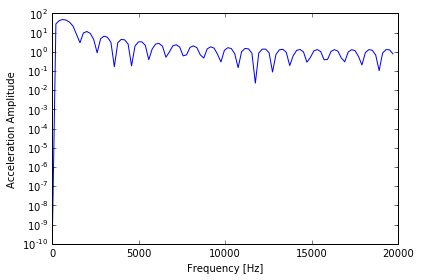

In [140]:
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # lower, bottom, width, height (range 0 to 1)
axes.semilogy(freq,abs(a))
axes.set_xlabel('Frequency [Hz]')
axes.set_ylabel('Acceleration Amplitude')
axes.set_title('');

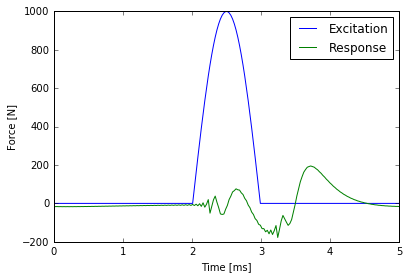

In [141]:
# Inverse FFT
y = N*irfft(a,N)/2
t_i = maketime(y,fs)

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # lower, bottom, width, height (range 0 to 1)
axes.plot(t*1000, x, label="Excitation")
axes.plot(t_i*1000,np.real(y),label="Response")
axes.legend()
axes.set_xlabel('Time [ms]')
axes.set_ylabel('Force [N]');

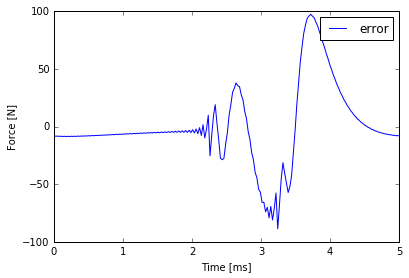

In [142]:
error = np.real(N*irfft(a,N)/2)-np.real(N*ifft(a,N)/2)
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # lower, bottom, width, height (range 0 to 1)
axes.plot(t*1000, error, label="error")
axes.legend()
axes.set_xlabel('Time [ms]')
axes.set_ylabel('Force [N]');